In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
from sklearn.metrics import mean_squared_error  # Ensure this import is included
import statsmodels.api as sm
from statsmodels.stats.power import FTestPower


In [5]:
# Load data from CSV file using pandas
data = pd.read_csv("/Users/urodas/Library/Mobile Documents/com~apple~CloudDocs/2024 Fall Semester/Quantitative Neuroscience/QNC Project Presentations/dose_response_multiple_drugs.csv")

In [6]:
# Group by 'dose' and 'drug' and calculate the mean response for each group
grouped_data = data.groupby(['dose', 'drug']).agg({'response': 'mean'}).reset_index()

In [7]:
# Define the sigmoid function (Hill equation) for the dose-response curve
def sigmoid(x, a, b, c):
    """
    Sigmoid function for dose-response curve.
    
    Parameters:
    - x: The independent variable (dose levels).
    - a: The maximum response (upper asymptote).
    - b: The EC50 (the dose for half-maximal response).
    - c: The Hill coefficient (slope).
    """
    return a / (1 + (x / b) ** c)

Results for UP109:
  R²: 0.9206
  Cohen's f²: 11.5949
  Mean Squared Error (MSE): 0.0011


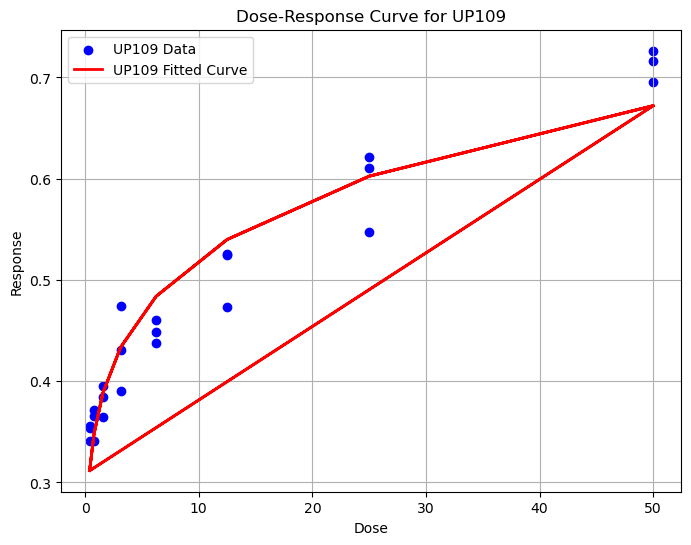

Results for UP109.3:
  R²: 0.9706
  Cohen's f²: 33.0444
  Mean Squared Error (MSE): 0.0005


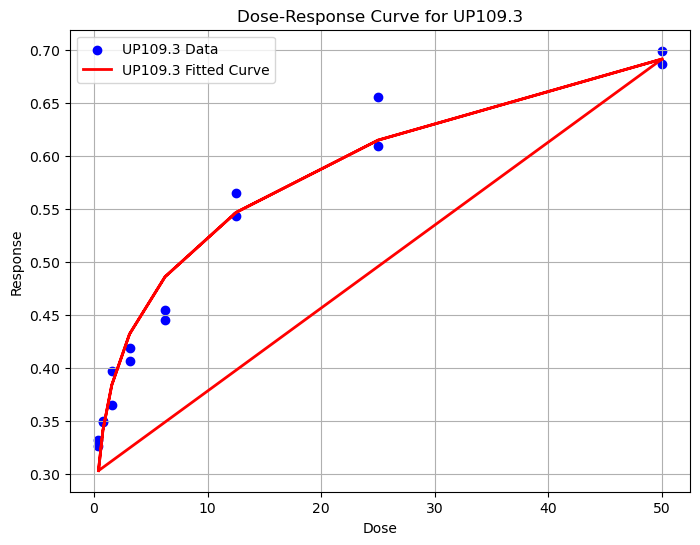

Results for UP109.13:
  R²: 0.9721
  Cohen's f²: 34.8454
  Mean Squared Error (MSE): 0.0004


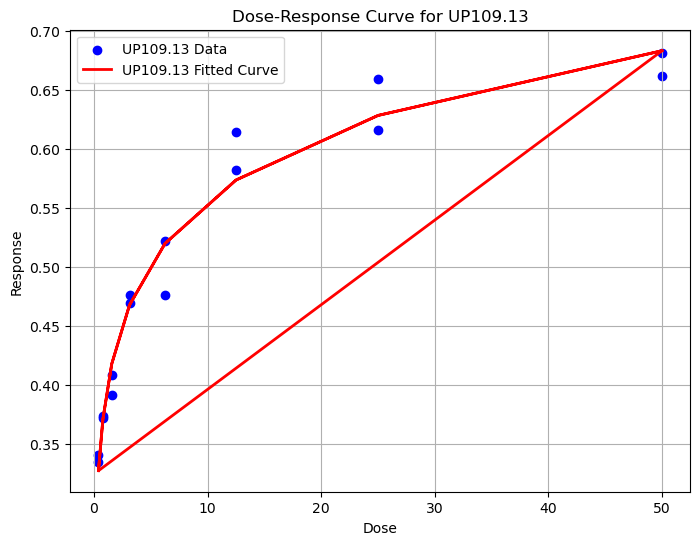

Results for UP109.21:
  R²: 0.8957
  Cohen's f²: 8.5839
  Mean Squared Error (MSE): 0.0016


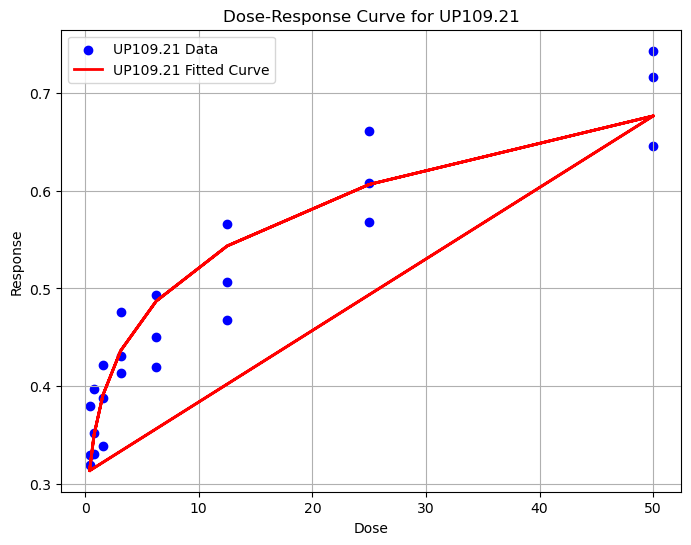

Results for UP109.22:
  R²: 0.9808
  Cohen's f²: 51.1163
  Mean Squared Error (MSE): 0.0003


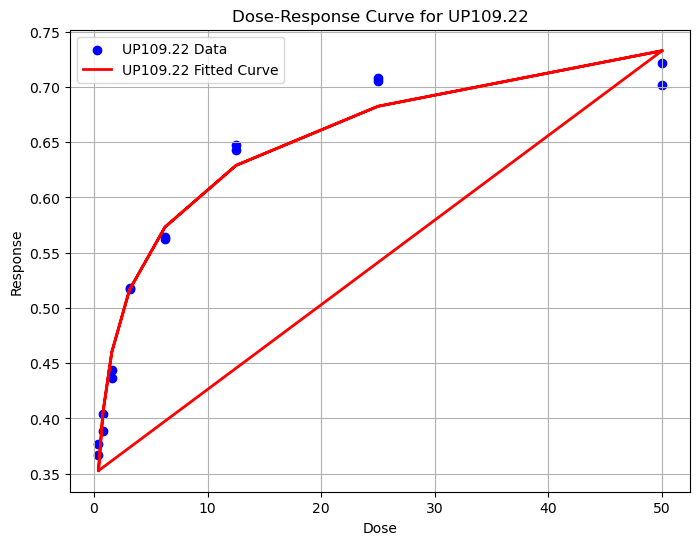

In [15]:
# Function to calculate Cohen's f²
def calculate_f2(r2):
    return r2 / (1 - r2)

# Loop through each unique drug in the data
# Use the correct column name for drugs based on your dataset
drugs = data['drug'].unique()  # Replace 'Drug' with the correct column name if necessary

for drug in drugs:
    # Filter the data for the current drug
    drug_data = data[data['drug'] == drug]  # Replace 'Drug' with the correct column name if necessary
    
    # Get the dose and response values (assume 'Dose' and 'Response' columns exist)
    dose = drug_data['dose'].values  # Replace 'Dose' with the actual column name if necessary
    response = drug_data['response'].values  # Replace 'Response' with the actual column name if necessary
    
    # Perform non-linear curve fitting using curve_fit with improved initial guesses and maxfev
    p0 = [max(response), 1, np.median(dose)]  # Initial guesses for parameters
    try:
        # Try fitting with a higher maxfev and alternative method ('trf')
        params, covariance = curve_fit(sigmoid, dose, response, p0, method='trf', maxfev=10000)
        
        # Get the predicted response using the fitted parameters
        predicted_response = sigmoid(dose, *params)
        
        # Calculate R² (Coefficient of Determination)
        residuals = response - predicted_response
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((response - np.mean(response))**2)
        r2 = 1 - (ss_res / ss_tot)
        
        # Calculate Cohen's f²
        f2 = calculate_f2(r2)
        
        # Calculate Mean Squared Error (MSE) for the fit
        mse = mean_squared_error(response, predicted_response)
        
        # Print results for the current drug
        print(f"Results for {drug}:")
        print(f"  R²: {r2:.4f}")
        print(f"  Cohen's f²: {f2:.4f}")
        print(f"  Mean Squared Error (MSE): {mse:.4f}")
        
        # Plot the data and the fitted sigmoid curve
        plt.figure(figsize=(8, 6))
        plt.scatter(dose, response, label=f'{drug} Data', color='blue')
        plt.plot(dose, predicted_response, label=f'{drug} Fitted Curve', color='red', linewidth=2)
        plt.xlabel('Dose')
        plt.ylabel('Response')
        plt.title(f'Dose-Response Curve for {drug}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    except RuntimeError as e:
        print(f"Error fitting {drug}: {e}")

In [17]:
# Define your drugs and their corresponding effect sizes (Cohen's f²)
# For each drug, you can either manually input or calculate Cohen's f² based on R²
drug_effect_sizes = {
    'UP109': 11.5949,  
    'UP109.3': 33.0444,  # Example: effect size for Drug B
    'UP109.13': 34.8454,   # Example: effect size for Drug C
    "UP109.21": 8.5839,
    "UP109.22": 51.1163
}

# Desired power and significance level
alpha = 0.05  # Significance level (alpha)
power = 0.80  # Desired power (80%)
num_predictors = 3  # Number of predictors (e.g., parameters in your nonlinear model)

# Perform power analysis for each drug
for drug, effect_size in drug_effect_sizes.items():
    # Create an FTestPower object for power analysis
    power_analysis = FTestPower()

    # Calculate the required sample size for 80% power
    # Since we are dealing with regression, df_num = num_predictors (number of parameters)
    df_num = num_predictors  # Number of parameters in your model (e.g., 3 for a sigmoid curve)
    
    # Approximate df_denom as sample size - df_num (This is an approximation)
    # We will leave it as None and calculate for a range of sample sizes
    sample_size = None

    # Start with an estimated range of sample sizes (e.g., 20 to 1000)
    # This range may need to be adjusted depending on your data and expected effect size
    sample_sizes = np.arange(20, 500, 5)

    for N in sample_sizes:
        # Approximate df_denom = N - df_num
        df_denom = N - df_num
        
        # Calculate power for each sample size
        power_estimate = power_analysis.solve_power(effect_size=effect_size, 
                                                    df_num=df_num, 
                                                    df_denom=df_denom, 
                                                    alpha=alpha, 
                                                    power=None)

        # Check if the calculated power meets the target power (80%)
        if power_estimate >= power:
            sample_size = N
            break

    print(f"Power analysis for {drug}:")
    print(f"  Effect Size (f²): {effect_size}")
    print(f"  Required Sample Size (N) for 80% Power: {sample_size}\n")



Power analysis for UP109:
  Effect Size (f²): 11.5949
  Required Sample Size (N) for 80% Power: 20

Power analysis for UP109.3:
  Effect Size (f²): 33.0444
  Required Sample Size (N) for 80% Power: 20

Power analysis for UP109.13:
  Effect Size (f²): 34.8454
  Required Sample Size (N) for 80% Power: 20

Power analysis for UP109.21:
  Effect Size (f²): 8.5839
  Required Sample Size (N) for 80% Power: 20

Power analysis for UP109.22:
  Effect Size (f²): 51.1163
  Required Sample Size (N) for 80% Power: 20



In [9]:
# Create a plot to compare dose-response curves for each drug
plt.figure(figsize=(10, 8))

# Get the list of unique drugs
drugs = grouped_data['drug'].unique()


<Figure size 1000x800 with 0 Axes>

Fitted parameters for UP109: a = 0.95, b = 0.00, c = 0.00
Fitted parameters for UP109.13: a = 1.00, b = 66.06, c = 0.00
Fitted parameters for UP109.21: a = 0.95, b = 113.30, c = 0.00
Fitted parameters for UP109.22: a = 1.09, b = 61.69, c = 0.00
Fitted parameters for UP109.3: a = 0.95, b = 104.90, c = 0.00


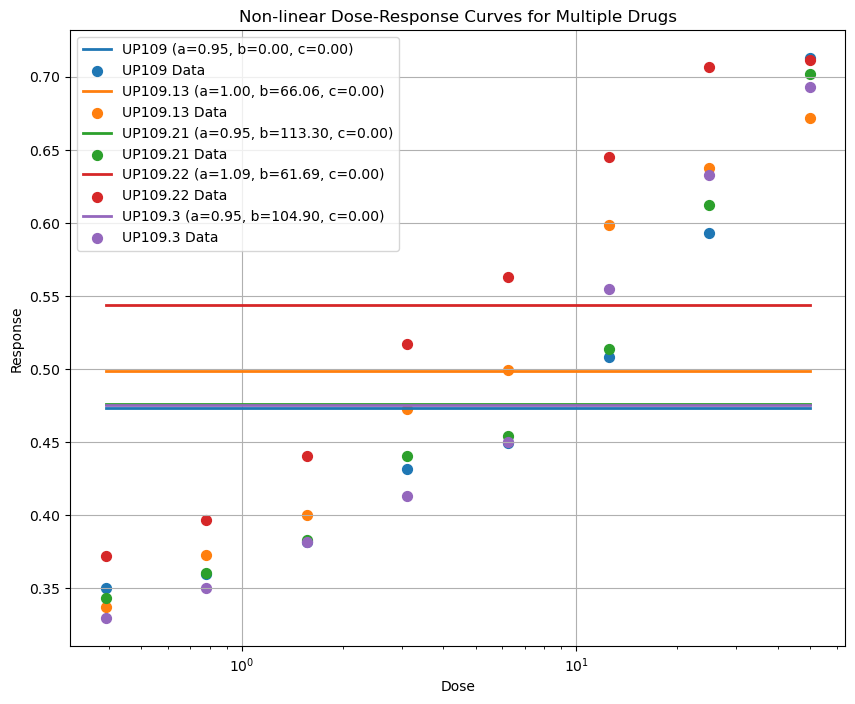

In [10]:
# Group by dose and drug, then calculate the mean response at each dose
grouped_data = data.groupby(['dose', 'drug']).agg({'response': 'mean'}).reset_index()

# Loop over each drug
plt.figure(figsize=(10, 8))
for drug in grouped_data['drug'].unique():
    # Extract dose and response data for this drug
    drug_data = grouped_data[grouped_data['drug'] == drug]
    dose = drug_data['dose'].values
    response = drug_data['response'].values

    # Check for missing or NaN values in the data
    if np.any(np.isnan(dose)) or np.any(np.isnan(response)):
        print(f"Skipping {drug} due to NaN values in the data.")
        continue

    # Provide a better initial guess for the parameters (a, b, c)
    p0 = [max(response), np.median(dose), 1]  # Max response, median dose, Hill coefficient
    
    try:
        # Perform non-linear curve fitting with bounds and increased maxfev
        params, params_covariance = curve_fit(
            sigmoid, 
            dose, 
            response, 
            p0=p0,  # Initial guess for parameters
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),  # Bounds for parameters
            maxfev=10000  # Increased number of evaluations
        )

        # Extract the fitted parameters
        a, b, c = params
        print(f"Fitted parameters for {drug}: a = {a:.2f}, b = {b:.2f}, c = {c:.2f}")

        # Generate x-values for the fitted curve
        x_vals = np.linspace(min(dose), max(dose), 100)
        y_vals = sigmoid(x_vals, *params)

        # Plot the data and fitted curve with labels for legend
        plt.plot(x_vals, y_vals, label=f'{drug} (a={a:.2f}, b={b:.2f}, c={c:.2f})', linewidth=2)  # Curve label
        plt.scatter(dose, response, label=f'{drug} Data', s=50)  # Data points label

    except RuntimeError as e:
        print(f"Fit failed for {drug}: {e}")

# Formatting the plot
plt.xscale('log')  # Log scale for x-axis
plt.xlabel('Dose')
plt.ylabel('Response')
plt.title('Non-linear Dose-Response Curves for Multiple Drugs')

# Display the legend
plt.legend(loc='best')  # 'best' automatically places the legend in the most suitable location

# Display grid
plt.grid(True)

# Show the plot
plt.show()

In [11]:
# Loop over each drug to fit the non-linear regression and calculate hypothesis tests
plt.figure(figsize=(10, 8))
for drug in grouped_data['drug'].unique():
    # Extract dose and response data for this drug
    drug_data = grouped_data[grouped_data['drug'] == drug]
    dose = drug_data['dose'].values
    response = drug_data['response'].values

    # Check for missing or NaN values in the data
    if np.any(np.isnan(dose)) or np.any(np.isnan(response)):
        print(f"Skipping {drug} due to NaN values in the data.")
        continue

    # Provide a better initial guess for the parameters (a, b, c)
    p0 = [max(response), np.median(dose), 1]  # Initial guess for a, b, c

    try:
        # Perform non-linear curve fitting with bounds and increased maxfev
        params, params_covariance = curve_fit(
            sigmoid, 
            dose, 
            response, 
            p0=p0,  # Initial guess for parameters
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),  # Bounds for parameters
            maxfev=10000  # Increased number of evaluations
        )

        # Extract the fitted parameters
        a, b, c = params
        print(f"Fitted parameters for {drug}: a = {a:.2f}, b = {b:.2f}, c = {c:.2f}")

        # Calculate the covariance matrix
        cov_matrix = params_covariance
        
        # Calculate the standard errors of the parameters (square root of diagonal elements of covariance matrix)
        se_a, se_b, se_c = np.sqrt(np.diag(cov_matrix))

        # Calculate the t-statistics for each parameter
        t_a = a / se_a
        t_b = b / se_b
        t_c = c / se_c

        # Degrees of freedom: Number of data points minus number of parameters
        df = len(dose) - len(params)

        # Calculate the p-values using the t-distribution
        p_a = 2 * (1 - stats.t.cdf(np.abs(t_a), df))  # Two-tailed test
        p_b = 2 * (1 - stats.t.cdf(np.abs(t_b), df))
        p_c = 2 * (1 - stats.t.cdf(np.abs(t_c), df))

        # Print the results
        print(f"Standard Errors: SE(a) = {se_a:.2f}, SE(b) = {se_b:.2f}, SE(c) = {se_c:.2f}")
        print(f"T-statistics: t(a) = {t_a:.2f}, t(b) = {t_b:.2f}, t(c) = {t_c:.2f}")
        print(f"P-values: p(a) = {p_a:.4f}, p(b) = {p_b:.4f}, p(c) = {p_c:.4f}\n")

    except RuntimeError as e:
        print(f"Fit failed for {drug}: {e}")


Fitted parameters for UP109: a = 0.95, b = 0.00, c = 0.00
Standard Errors: SE(a) = 1.71, SE(b) = 14747444.05, SE(c) = 0.15
T-statistics: t(a) = 0.55, t(b) = 0.00, t(c) = 0.00
P-values: p(a) = 0.6033, p(b) = 1.0000, p(c) = 1.0000

Fitted parameters for UP109.13: a = 1.00, b = 66.06, c = 0.00
Standard Errors: SE(a) = 0.21, SE(b) = 0.00, SE(c) = 0.13
T-statistics: t(a) = 4.78, t(b) = inf, t(c) = 0.00
P-values: p(a) = 0.0050, p(b) = 0.0000, p(c) = 1.0000

Fitted parameters for UP109.21: a = 0.95, b = 113.30, c = 0.00
Standard Errors: SE(a) = 0.24, SE(b) = 0.00, SE(c) = 0.14
T-statistics: t(a) = 3.94, t(b) = inf, t(c) = 0.00
P-values: p(a) = 0.0109, p(b) = 0.0000, p(c) = 1.0000

Fitted parameters for UP109.22: a = 1.09, b = 61.69, c = 0.00
Standard Errors: SE(a) = 0.22, SE(b) = 0.00, SE(c) = 0.13
T-statistics: t(a) = 4.96, t(b) = inf, t(c) = 0.00
P-values: p(a) = 0.0042, p(b) = 0.0000, p(c) = 1.0000

Fitted parameters for UP109.3: a = 0.95, b = 104.90, c = 0.00
Standard Errors: SE(a) = 0.25

/var/folders/vj/dj1sw4490b357sf04kgc67jw0000gp/T/ipykernel_47905/3768280872.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  t_b = b / se_b


<Figure size 1000x800 with 0 Axes>

In [2]:
#Using Python to generate simulated data
import numpy as np

# Function to generate data for one condition
def generate_condition_data(mean_target, n, lower_bound=0.15, upper_bound=0.3):
    while True:
        data = np.random.uniform(lower_bound, upper_bound, n)
        if np.mean(data) > mean_target:
            return data

# Target mean hierarchy for the conditions
conditions = {
    "UP109": 0.15,
    "UP109.21": 0.19,
    "UP109.3": 0.23,
    "UP109.13": 0.28,
    "UP109.22": 0.30
}

# Generate data for each condition
n = 4  # Number of points per condition
simulated_data = {condition: generate_condition_data(mean_target, n) for condition, mean_target in conditions.items()}

# Print the simulated data
for condition, data in simulated_data.items():
    print(f"{condition}: {data}, Mean: {np.mean(data):.3f}")
